In [2]:
import pandas as pd
from datasets import load_from_disk
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline

In [4]:
ds = load_from_disk('../data/efcamdat_dataset')
model = AutoModelForSequenceClassification.from_pretrained('../bin/efcamdat_nli_1')
tokenizer = AutoTokenizer.from_pretrained('../bin/efcamdat_nli_1')

In [5]:
label_names = ds['test'].features['labels'].names

id2label = {idnum: label for idnum, label in enumerate(label_names)}
label2id = {label: idnum for idnum, label in enumerate(label_names)}

model.config.id2label = id2label
model.config.label2id = label2id

# Pipeline for individual results

In [4]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=0)

In [5]:
preds = pipe(ds['test']['text'], top_k=1)

In [ ]:
df = ds['test'].to_pandas()
df['labels'] = df['labels'].map(id2label)
df['preds'] = [pred[0]['label'] for pred in preds]
df.to_csv('../data/test_prediction_results.csv')

In [6]:
from sklearn.metrics import classification_report
df = pd.read_csv('../data/test_prediction_results.csv', index_col=0)

df = df.loc[df['cefr'].isin(['A1', 'A2', 'B1'])]
print(classification_report(df['preds'], df['labels']))

              precision    recall  f1-score   support

      Arabic       0.86      0.83      0.84      2806
      German       0.80      0.84      0.82      2418
    Mandarin       0.90      0.86      0.88      3005
  Portuguese       0.74      0.80      0.77      2455
     Russian       0.83      0.82      0.82      2807
     Spanish       0.80      0.79      0.80      2843

    accuracy                           0.82     16334
   macro avg       0.82      0.82      0.82     16334
weighted avg       0.82      0.82      0.82     16334



## Confusion Matrix

In [65]:
assert preds[1][0]['label'] == id2label[ds['test']['labels'][1]]

In [68]:
y_true = [id2label[lab] for lab in ds['test']['labels']]
y_pred = [pred[0]['label'] for pred in preds]

In [156]:
y_true = df['labels']
y_pred = df['preds']

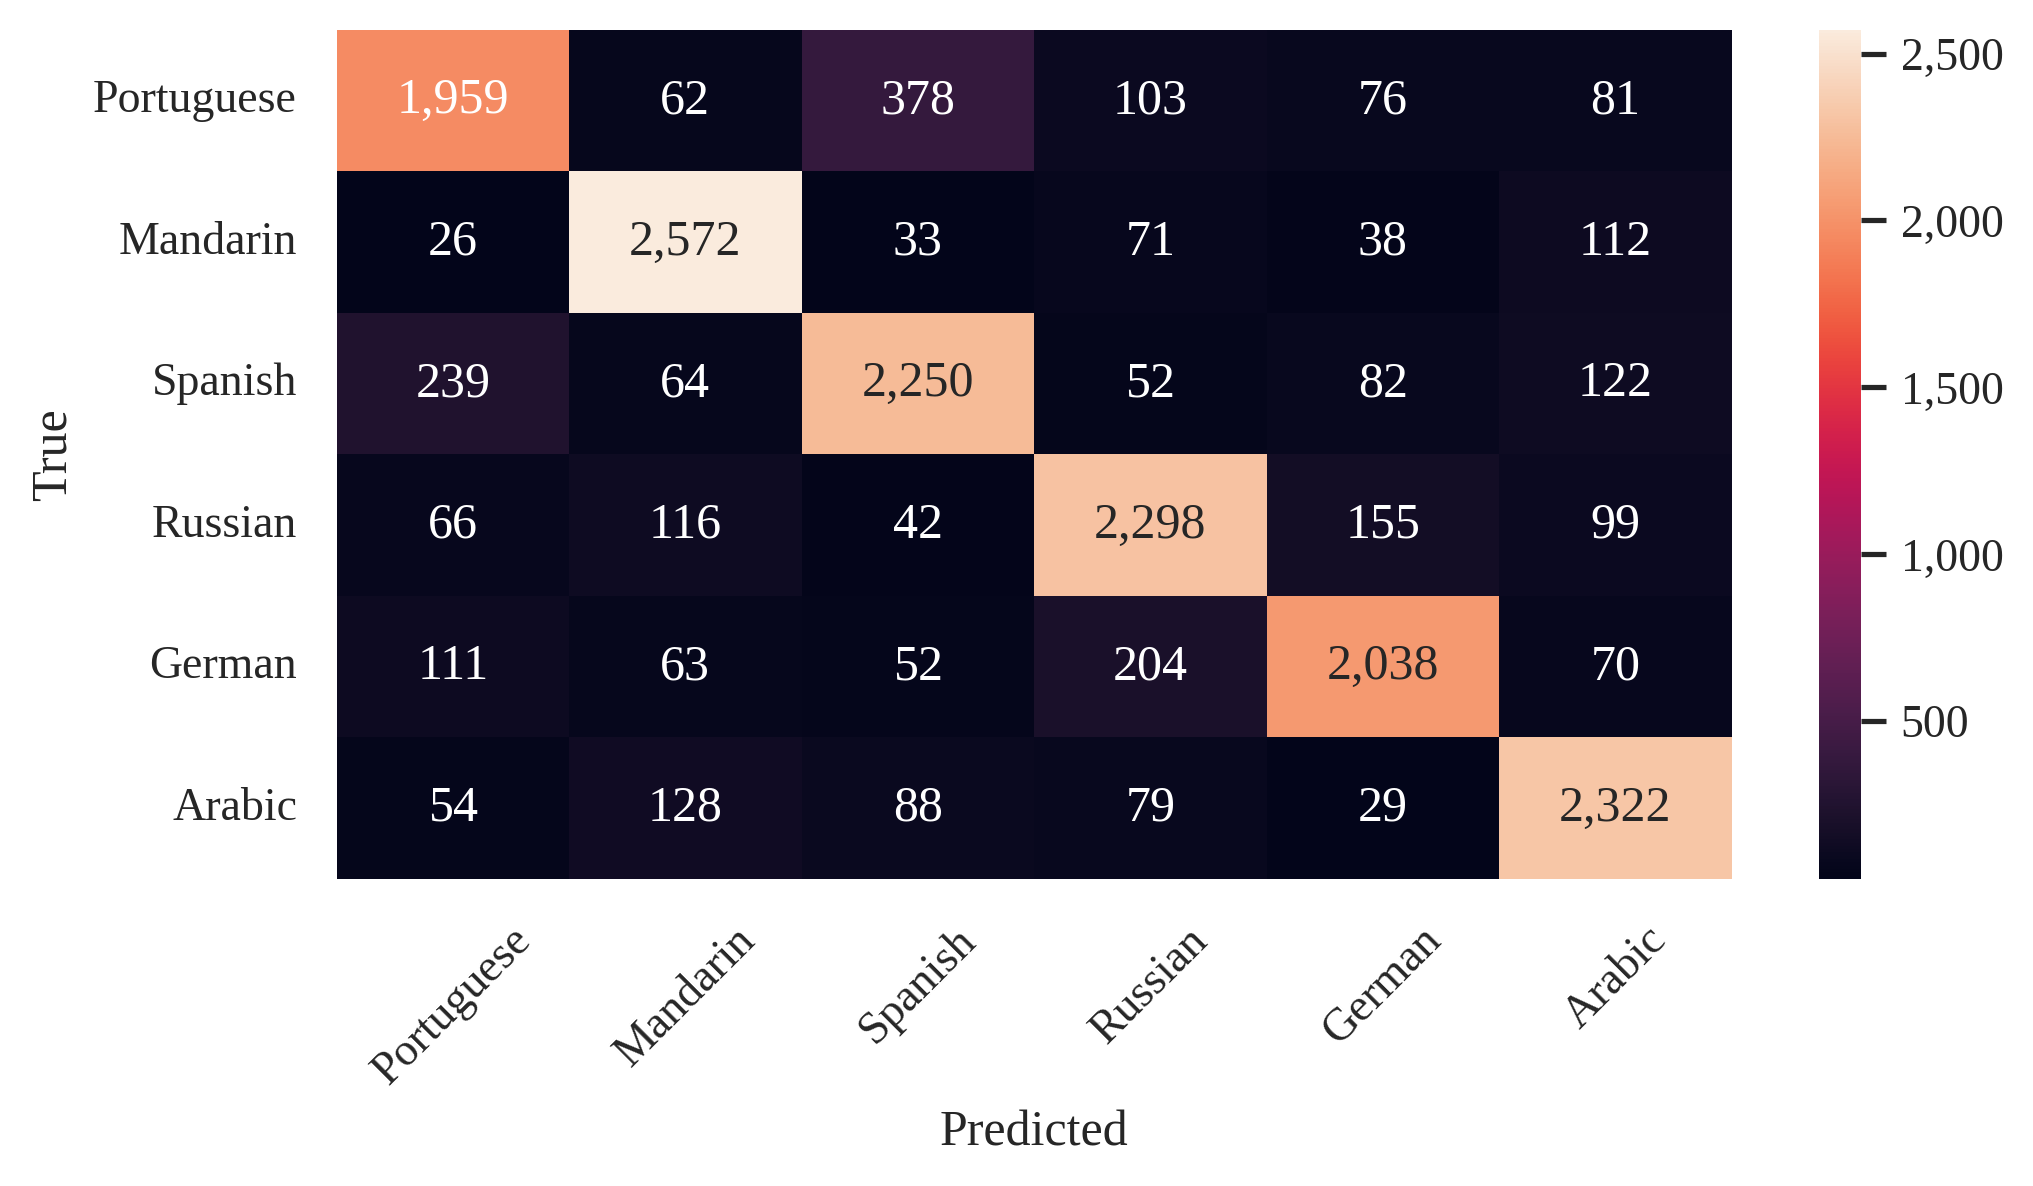

In [157]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import seaborn.objects as so
sns.set_theme(font='Liberation Serif',
              rc={'figure.figsize': (7.5,3.75),
                  'font.size': 12,
                  'figure.dpi': 300,
                  'axes.formatter.use_locale': True,
                 })
comma_formatter = lambda x, _: f'{int(x):,d}'

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, labels=label_names)

g = sns.heatmap(cm, annot=True, fmt=',', cbar_kws={'format': comma_formatter})
g.legend_
g.set_xticklabels(label_names, rotation=45)
g.set_yticklabels(label_names, rotation=0)
g.set(xlabel='Predicted',
      ylabel='True',
     )
plt.savefig('../images/confusion-matrix-1.png')

## Classification Report with Subsets

### By CEFR

In [148]:
def crp(sub_df, title_str=''):
    print(title_str)
    print(classification_report(sub_df['preds'], sub_df['labels']))

for level in ['A1', 'A2', 'B1', 'B2']:
    crp(df[df['cefr']==level], title_str=f'Classification Report for CEFR {level}:')

Classification Report for CEFR A1:
              precision    recall  f1-score   support

      Arabic       0.85      0.85      0.85      1526
      German       0.75      0.80      0.78       862
    Mandarin       0.91      0.85      0.88      1555
  Portuguese       0.77      0.80      0.78      1381
     Russian       0.81      0.82      0.81      1240
     Spanish       0.81      0.80      0.80      1646

    accuracy                           0.82      8210
   macro avg       0.82      0.82      0.82      8210
weighted avg       0.82      0.82      0.82      8210

Classification Report for CEFR A2:
              precision    recall  f1-score   support

      Arabic       0.88      0.81      0.84       934
      German       0.80      0.86      0.83       859
    Mandarin       0.90      0.87      0.89      1051
  Portuguese       0.70      0.78      0.74       707
     Russian       0.84      0.82      0.83      1008
     Spanish       0.79      0.78      0.79       775

    acc

### By grade

In [35]:
df.groupby(
    pd.qcut(
        df['grade'],
        3,
        precision=0,
    )
).apply(lambda x: crp(x, title_str=f'Classification Report for texts graded within the interval {x.name}:'))

Classification Report for texts graded within the interval (9.0, 90.0]:
              precision    recall  f1-score   support

      Arabic       0.87      0.85      0.86      2010
      German       0.82      0.86      0.84      1460
    Mandarin       0.91      0.86      0.88      1754
  Portuguese       0.74      0.80      0.77      1514
     Russian       0.84      0.82      0.83      1514
     Spanish       0.82      0.80      0.81      1893

    accuracy                           0.83     10145
   macro avg       0.83      0.83      0.83     10145
weighted avg       0.83      0.83      0.83     10145

Classification Report for texts graded within the interval (90.0, 95.0]:
              precision    recall  f1-score   support

      Arabic       0.84      0.77      0.80       717
      German       0.80      0.86      0.83       899
    Mandarin       0.89      0.84      0.86       875
  Portuguese       0.73      0.80      0.76       720
     Russian       0.81      0.81      0.

""


### By tok_count

In [24]:
df['toks'] = df['text'].str.split(' ').str.len()

In [36]:
df.groupby(
    pd.qcut(
        df['toks'],
        3,
        precision=0,
        # labels=['low', 'medium', 'high'],
        # ordered=True,
    )
).apply(lambda x: crp(x, title_str=f'Classification Report for texts with a token count within the interval {x.name}:'))

Classification Report for texts with a token count within the interval (4.0, 43.0]:
              precision    recall  f1-score   support

      Arabic       0.85      0.84      0.85      1189
      German       0.75      0.80      0.78       620
    Mandarin       0.90      0.83      0.87      1095
  Portuguese       0.77      0.80      0.78      1049
     Russian       0.79      0.81      0.80       908
     Spanish       0.80      0.79      0.79      1144

    accuracy                           0.81      6005
   macro avg       0.81      0.81      0.81      6005
weighted avg       0.82      0.81      0.81      6005

Classification Report for texts with a token count within the interval (43.0, 73.0]:
              precision    recall  f1-score   support

      Arabic       0.86      0.82      0.84      1068
      German       0.78      0.85      0.81       848
    Mandarin       0.91      0.86      0.88      1109
  Portuguese       0.71      0.78      0.75       867
     Russian     

""


# Evaluator for gross results

In [37]:
from evaluate import evaluator

task_evaluator = evaluator('text-classification')

results = task_evaluator.compute(
    model_or_pipeline=model,
    tokenizer=tokenizer,
    label_column='labels',
    data=ds['test'].select(range(100)),
    metric='accuracy',
    label_mapping=label2id,
    strategy='bootstrap',
    n_resamples=10,
    random_state=0
)

In [38]:
results

{'accuracy': {'confidence_interval': (0.7317688574347153, 0.8388931955148324),
  'standard_error': 0.036270588023294525,
  'score': 0.8},
 'total_time_in_seconds': 0.735568867996335,
 'samples_per_second': 135.9492011569177,
 'latency_in_seconds': 0.007355688679963351}